In [1]:
import numpy as np

In [5]:
h = 200e-6
l = 500e-6
P0 = 10e-3
L0 = 64e-3
L12 = 2e-3
L23 = 2e-3
gamma = 0.0728
theta = 45
rho = 1000
a = 2e-3
D = 2.9e-3
# à faire varier
V0 = 8e-9


--- PARAMÈTRES ---
L1=60.00 mm, L2=1.00 mm, L4=1.00 mm
V0 injecté = 10.000 µL
Résistances (Pa·s/m³): R1=2.406e+11, R2=4.011e+09, R4=4.011e+09
Capacités (m³/Pa): C0=6.733e-10, C1=3.202e-10

--- VOLUMES ÉCOULÉS APRÈS 10 s ---
Trou Raman 1 : 0.1930 µL
Trou Raman 2 : 0.1220 µL
Trou Raman 3 : 0.0589 µL
Somme totale : 0.3739 µL (≈ V0 ?)


C:\Users\33767\AppData\Local\Temp\ipykernel_14776\1212273481.py:80: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V1 = np.trapz(i1, t)
C:\Users\33767\AppData\Local\Temp\ipykernel_14776\1212273481.py:81: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V5 = np.trapz(i5, t)
C:\Users\33767\AppData\Local\Temp\ipykernel_14776\1212273481.py:82: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V6 = np.trapz(i6, t)


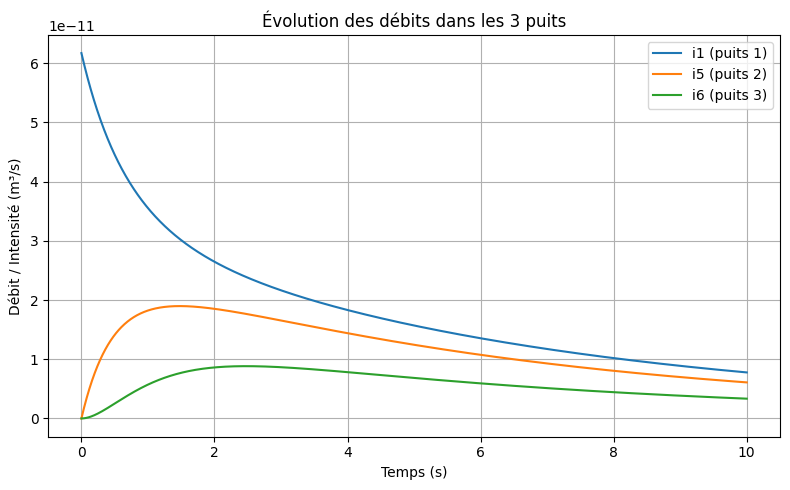

In [ ]:
"""
Simulation du circuit hydraulique équivalent (RC)
-------------------------------------------------
Ce script calcule et trace les intensités (débits) i1, i5, i6 en fonction du temps
et le volume total écoulé dans chaque puits Raman après 10 s
"""

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Constantes physiques
# ------------------------------
mu = 1e-3      # viscosité dynamique de l'eau (Pa·s)
rho = 1000.0   # densité de l'eau (kg/m³)
g = 9.81       # gravité (m/s²)
pi = np.pi

# ------------------------------
# Fonctions auxiliaires
# ------------------------------
def R_chan(L, w, h, mu):
    """Résistance hydraulique d'un canal rectangulaire."""
    factor = 1.0 - 0.63 * (h / w)
    return (12 * mu * L) / (w * h**3 * factor)

def compute_currents(L1, L2, L4, V0, t_final=100.0):
    """Calcule les courants i1, i5, i6(t) selon les longueurs et V0."""
    # --- Géométrie
    h = 200e-6     # hauteur canal (m)
    w = 500e-6     # largeur canal (m)
    A0 = pi * (2.9e-3 / 2)**2  # aire d'entrée (m²)
    A = pi * (1e-3)**2         # aire des puits (m²)

    # --- Compliances
    C0 = A0 / (rho * g)
    C1 = C2 = C3 = A / (rho * g)

    # --- Résistances hydrauliques
    R1 = R_chan(L1, w, h, mu)
    R2 = R_chan(L2, w, h, mu)
    R3 = R2
    R4 = R_chan(L4, w, h, mu)

    # --- Matrices
    M = -np.diag([C0, C1, C2, C3])
    g1, g2, g3, g4 = 1/R1, 1/R2, 1/R3, 1/R4

    R_mat = np.array([
        [ g1,       -g1,        0.0,         0.0],
        [ g1,  -g1 - g2,       g2,          0.0],
        [ 0.0,       g2,    -2.0*g2,       g2],
        [ 0.0,       0.0,       g3,   -g3 - g4]
    ])

    A_mat = np.linalg.inv(M) @ R_mat

    # --- Conditions initiales
    v0 = np.array([V0 / C0, 0, 0, 0])

    # --- Discrétisation temporelle
    nt = 1500
    t = np.linspace(0, t_final, nt)

    # --- Résolution par diagonalisation
    eigvals, S = np.linalg.eig(A_mat)
    S_inv = np.linalg.inv(S)
    V_t = np.zeros((nt, 4))
    for k, ti in enumerate(t):
        D = np.diag(np.exp(-eigvals * ti))
        V_t[k, :] = (S @ D @ S_inv @ v0).real

    # --- Courants : i = R_mat * v
    I_t = (R_mat @ V_t.T).T
    i1, i5, i6 = I_t[:, 1], I_t[:, 2], I_t[:, 3]

    # --- Volumes écoulés (intégration numérique)
    V1 = np.trapz(i1, t)
    V5 = np.trapz(i5, t)
    V6 = np.trapz(i6, t)

    return t, i1, i5, i6, (R1, R2, R3, R4), (C0, C1, C2, C3), (V1, V5, V6)

# ------------------------------
# Entrée utilisateur
# ------------------------------
try:
    L1 = float(input("Longueur L1 (mm) [ex: 4] : ")) * 1e-3
    L2 = float(input("Longueur L2 (mm) [ex: 2] : ")) * 1e-3
    L4 = float(input("Longueur L4 (mm) [ex: 2] : ")) * 1e-3
    V0 = float(input("Volume injecté V0 (µL) [ex: 10] : ")) * 1e-9
except ValueError:
    print("Entrée invalide. Utilisation des valeurs par défaut.")
    L1, L2, L4, V0 = 4e-3, 2e-3, 2e-3, 10e-9

# ------------------------------
# Calcul et affichage
# ------------------------------
t, i1, i5, i6, Rvals, Cvals, Vtot = compute_currents(L1, L2, L4, V0, t_final=10.0)

# --- Affichage des résultats numériques
print("\n--- PARAMÈTRES ---")
print(f"L1={L1*1e3:.2f} mm, L2={L2*1e3:.2f} mm, L4={L4*1e3:.2f} mm")
print(f"V0 injecté = {V0*1e9:.3f} µL")
print(f"Résistances (Pa·s/m³): R1={Rvals[0]:.3e}, R2={Rvals[1]:.3e}, R4={Rvals[3]:.3e}")
print(f"Capacités (m³/Pa): C0={Cvals[0]:.3e}, C1={Cvals[1]:.3e}")

print("\n--- VOLUMES ÉCOULÉS APRÈS 10 s ---")
print(f"Trou Raman 1 : {Vtot[0]*1e9:.4f} µL")
print(f"Trou Raman 2 : {Vtot[1]*1e9:.4f} µL")
print(f"Trou Raman 3 : {Vtot[2]*1e9:.4f} µL")
print(f"Somme totale : {(sum(Vtot))*1e9:.4f} µL (≈ V0 ?)")

# --- Tracé des courants
plt.figure(figsize=(8,5))
plt.plot(t, i1, label="i1 (puits 1)")
plt.plot(t, i5, label="i5 (puits 2)")
plt.plot(t, i6, label="i6 (puits 3)")
plt.xlabel("Temps (s)")
plt.ylabel("Débit / Intensité (m³/s)")
plt.title("Évolution des débits dans les 3 puits")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
print(np.pi*1e-6*2e-3 * 1e9 )

6.283185307179586



--- PARAMÈTRES ---
L1=20.00 mm, L2=5.00 mm, L4=5.00 mm
Vmax autorisé par trou = 6.000 µL

Coefficients k_i (V_i = k_i * V0) :
Trou 1 : k1=0.162,  Trou 2 : k5=0.084,  Trou 3 : k6=0.034

=> Volume injecté maximal V0_max = 37.118 µL

--- VOLUMES ÉCOULÉS POUR V0_max ---
Trou Raman 1 : 6.0000 µL
Trou Raman 2 : 3.1024 µL
Trou Raman 3 : 1.2690 µL


C:\Users\33767\AppData\Local\Temp\ipykernel_22208\1601671484.py:71: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V1 = np.trapz(i1, t)
C:\Users\33767\AppData\Local\Temp\ipykernel_22208\1601671484.py:72: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V5 = np.trapz(i5, t)
C:\Users\33767\AppData\Local\Temp\ipykernel_22208\1601671484.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  V6 = np.trapz(i6, t)


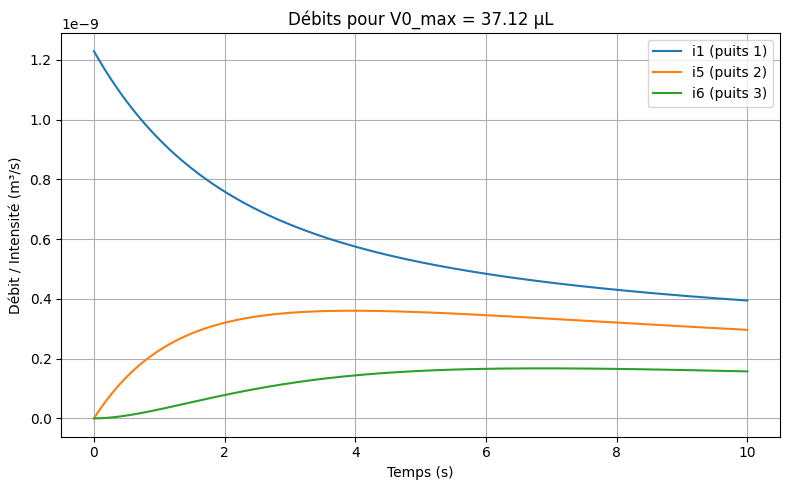

In [4]:
"""
Simulation du circuit hydraulique équivalent (RC)
-------------------------------------------------
Ce script :
 - calcule les débits i1, i5, i6(t)
 - intègre les volumes écoulés dans chaque trou Raman
 - détermine le V0 maximal tel que chacun reste < Vmax (fourni)

"""

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Constantes physiques
# ------------------------------
mu = 1e-3      # viscosité dynamique (Pa·s)
rho = 1000.0   # densité (kg/m³)
g = 9.81       # gravité (m/s²)
pi = np.pi

# ------------------------------
# Fonctions auxiliaires
# ------------------------------
def R_chan(L, w, h, mu):
    """Résistance hydraulique d'un canal rectangulaire."""
    factor = 1.0 - 0.63 * (h / w)
    return (12 * mu * L) / (w * h**3 * factor)

def compute_volumes(L1, L2, L4, V0, t_final=10.0):
    """Renvoie les volumes écoulés dans chaque trou Raman pour un volume injecté V0."""
    h = 250e-6
    w = 500e-6
    A0 = pi * (2.9e-3 / 2)**2
    A = pi * (1e-3)**2

    C0 = A0 / (rho * g)
    C1 = C2 = C3 = A / (rho * g)

    R1 = R_chan(L1, w, h, mu)
    R2 = R_chan(L2, w, h, mu)
    R3 = R2
    R4 = R_chan(L4, w, h, mu)

    M = -np.diag([C0, C1, C2, C3])
    g1, g2, g3, g4 = 1/R1, 1/R2, 1/R3, 1/R4

    R_mat = np.array([
        [ g1,       -g1,        0.0,         0.0],
        [ g1,  -g1 - g2,       g2,          0.0],
        [ 0.0,       g2,    -2.0*g2,       g2],
        [ 0.0,       0.0,       g3,   -g3 - g4]
    ])

    A_mat = np.linalg.inv(M) @ R_mat

    v0 = np.array([V0 / C0, 0, 0, 0])
    nt = 1500
    t = np.linspace(0, t_final, nt)

    eigvals, S = np.linalg.eig(A_mat)
    S_inv = np.linalg.inv(S)
    V_t = np.zeros((nt, 4))
    for k, ti in enumerate(t):
        D = np.diag(np.exp(-eigvals * ti))
        V_t[k, :] = (S @ D @ S_inv @ v0).real

    I_t = (R_mat @ V_t.T).T
    i1, i5, i6 = I_t[:, 1], I_t[:, 2], I_t[:, 3]

    V1 = np.trapz(i1, t)
    V5 = np.trapz(i5, t)
    V6 = np.trapz(i6, t)
    return V1, V5, V6, t, i1, i5, i6

# ------------------------------
# Entrée utilisateur
# ------------------------------
try:
    L1 = float(input("Longueur L1 (mm) [ex: 4] : ")) * 1e-3
    L2 = float(input("Longueur L2 (mm) [ex: 2] : ")) * 1e-3
    L4 = float(input("Longueur L4 (mm) [ex: 2] : ")) * 1e-3
    Vmax = float(input("Volume maximal par trou (µL) [ex: 2] : ")) * 1e-9
except ValueError:
    print("Entrée invalide. Utilisation des valeurs par défaut.")
    L1, L2, L4, Vmax = 4e-3, 2e-3, 2e-3, 2e-9

# ------------------------------
# Calcul du coefficient de proportionnalité
# ------------------------------
V_test = 1e-9  # 1 µL
V1_test, V5_test, V6_test, t, i1, i5, i6 = compute_volumes(L1, L2, L4, V_test)

# Chaque volume écoulé est proportionnel à V0 → V_i = k_i * V0
k1, k5, k6 = V1_test / V_test, V5_test / V_test, V6_test / V_test
V0_max = min(Vmax / k1, Vmax / k5, Vmax / k6)

# ------------------------------
# Résultats et tracé
# ------------------------------
print("\n--- PARAMÈTRES ---")
print(f"L1={L1*1e3:.2f} mm, L2={L2*1e3:.2f} mm, L4={L4*1e3:.2f} mm")
print(f"Vmax autorisé par trou = {Vmax*1e9:.3f} µL")
print(f"\nCoefficients k_i (V_i = k_i * V0) :")
print(f"Trou 1 : k1={k1:.3f},  Trou 2 : k5={k5:.3f},  Trou 3 : k6={k6:.3f}")
print(f"\n=> Volume injecté maximal V0_max = {V0_max*1e9:.3f} µL")

# Vérification : recalcul avec V0_max
V1, V5, V6, t, i1, i5, i6 = compute_volumes(L1, L2, L4, V0_max)

print("\n--- VOLUMES ÉCOULÉS POUR V0_max ---")
print(f"Trou Raman 1 : {V1*1e9:.4f} µL")
print(f"Trou Raman 2 : {V5*1e9:.4f} µL")
print(f"Trou Raman 3 : {V6*1e9:.4f} µL")

# --- Tracé des débits
plt.figure(figsize=(8,5))
plt.plot(t, i1, label="i1 (puits 1)")
plt.plot(t, i5, label="i5 (puits 2)")
plt.plot(t, i6, label="i6 (puits 3)")
plt.xlabel("Temps (s)")
plt.ylabel("Débit / Intensité (m³/s)")
plt.title(f"Débits pour V0_max = {V0_max*1e9:.2f} µL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
